In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/the-history-of-baseball/readme.txt
/kaggle/input/the-history-of-baseball/pitching_postseason.csv
/kaggle/input/the-history-of-baseball/batting_postseason.csv
/kaggle/input/the-history-of-baseball/fielding_postseason.csv
/kaggle/input/the-history-of-baseball/salary.csv
/kaggle/input/the-history-of-baseball/college.csv
/kaggle/input/the-history-of-baseball/manager.csv
/kaggle/input/the-history-of-baseball/hall_of_fame.csv
/kaggle/input/the-history-of-baseball/player_award.csv
/kaggle/input/the-history-of-baseball/team_franchise.csv
/kaggle/input/the-history-of-baseball/manager_award.csv
/kaggle/input/the-history-of-baseball/database.sqlite
/kaggle/input/the-history-of-baseball/player_college.csv
/kaggle/input/the-history-of-baseball/player.csv
/kaggle/input/the-history-of-baseball/team_half.csv
/kaggle/input/the-history-of-baseball/all_star.csv
/kaggle/input/the-history-of-baseball/park.csv
/kaggle/input/the-history-of-baseball/batting.csv
/kaggle/input/the-history-of-baseb

### **Preparing the Data **
First reading data for players in the hall of fame and data for players position.

In [424]:
hall_fame = pd.read_csv('/kaggle/input/the-history-of-baseball/hall_of_fame.csv',usecols=['player_id','yearid','inducted'])
pos = pd.read_csv('/kaggle/input/the-history-of-baseball/appearances.csv')

In [425]:
def position_dict(df):
    """Function that sums the number of times a player played at each position and inserts the max played position to a dictionary with the player_id."""
    players=df.player_id.unique()
    positions = ['g_p', 'g_c', 'g_1b', 'g_2b', 'g_3b', 'g_ss', 'g_lf','g_cf', 'g_rf']
    hf_position=[]
    
    for player in players:
        position=pos[pos.player_id==player][positions].sum().sort_values().index[-1]  
        hf_position.append(position)
        
    return dict(zip(players, np.array(hf_position))) 

positions=position_dict(hall_fame)

# Appending new column to 'hall of fame' with the position of each player from the dictionary.
hall_fame['position']=0
for i in range(len(hall_fame)):
    hall_fame.loc[i,'position']=positions[hall_fame.loc[i,'player_id']]

Now, let's look out the distribution of players by position that are inducted in the hall of fame. 

        No  Yes    percent
g_p   1233   73   4.724919
g_c    341   19   2.909648
g_1b   372   24   3.508772
g_2b   252   23   4.078014
g_3b   260   16   2.797203
g_ss   385   23   3.299857
g_lf   289   21   3.494176
g_cf   315   21   3.349282
g_rf   361   92  13.670134


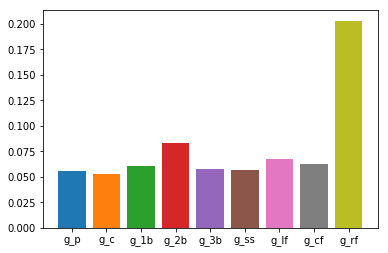

In [426]:
positions=['g_p', 'g_c', 'g_1b', 'g_2b', 'g_3b', 'g_ss', 'g_lf','g_cf', 'g_rf']
def percent_inducted(df):
    table = pd.DataFrame(index=['No','Yes'])
    for p in positions:
        table[p]=np.array(df.groupby('position').get_group(p)['inducted'].value_counts())
    table=table.T
    table['percent']=table['Yes']/sum(table['Yes'],table['No'])*100
    return table

print(percent_inducted(hall_fame))

for p in positions:
    hf=np.array(hall_fame.groupby('position').get_group(p)['inducted'].value_counts())
    plt.bar(p,hf[1]/sum(hf))
    
plt.show()

Looks like right field produces a much larger amount of hall of famers! Also noted is the population size of pitchers versus regular fielders. With this fact and the fact that pitchers are judged on completely different criteria (hitting and fielding are not important), I will only omit them for a separate model. Also, many players are voted for hall of fame induction for different years. So I'll create a dataframe of unique players from the hall of fame data base with a value of 1 if they were ever inducted and a value of 0 otherwise.

In [427]:
hall_fame = hall_fame[hall_fame.position != 'g_p'].reset_index(drop=True) # Getting rid of pitchers.

batters = hall_fame.player_id.unique()
inducted = hall_fame[hall_fame.inducted=='Y'][['player_id']].reset_index(drop=True)
n_inducted = pd.DataFrame({'player_id':[i for i in batters if i not in list(inducted.player_id)]}) # Every player in that was never inducted.

inducted['inducted']=1
n_inducted['inducted']=0

inducted_all = pd.concat([inducted,n_inducted]).sample(frac=1).reset_index(drop=True) # Concatenating dataframes and re-ordering.

Now with this base data frame, I will add features that I think may be relevent. For the batting and fielding dataframes, I calculate the mean values for each player. I also use the player_award dataframe and count the total number of awards each player has received. 

In [428]:
batting = pd.read_csv('/kaggle/input/the-history-of-baseball/batting.csv',usecols=['player_id','ab','r','h','double','hr','rbi','bb','so']).groupby('player_id').mean() 
award = pd.read_csv('/kaggle/input/the-history-of-baseball/player_award.csv',usecols=['player_id','award_id']).groupby('player_id').count().rename(columns={'award_id':'awards'})
fielding = pd.read_csv('/kaggle/input/the-history-of-baseball/fielding.csv',usecols=['player_id','g','po','e']).groupby('player_id').mean()

Finally merging everything together in a method chain.

In [429]:
data = (inducted_all.merge(batting,how='inner',on='player_id')
        .merge(fielding,how='inner',on='player_id').dropna()
        .merge(award, how='left',on='player_id').fillna(0)) # Assuming NaN is no awards.

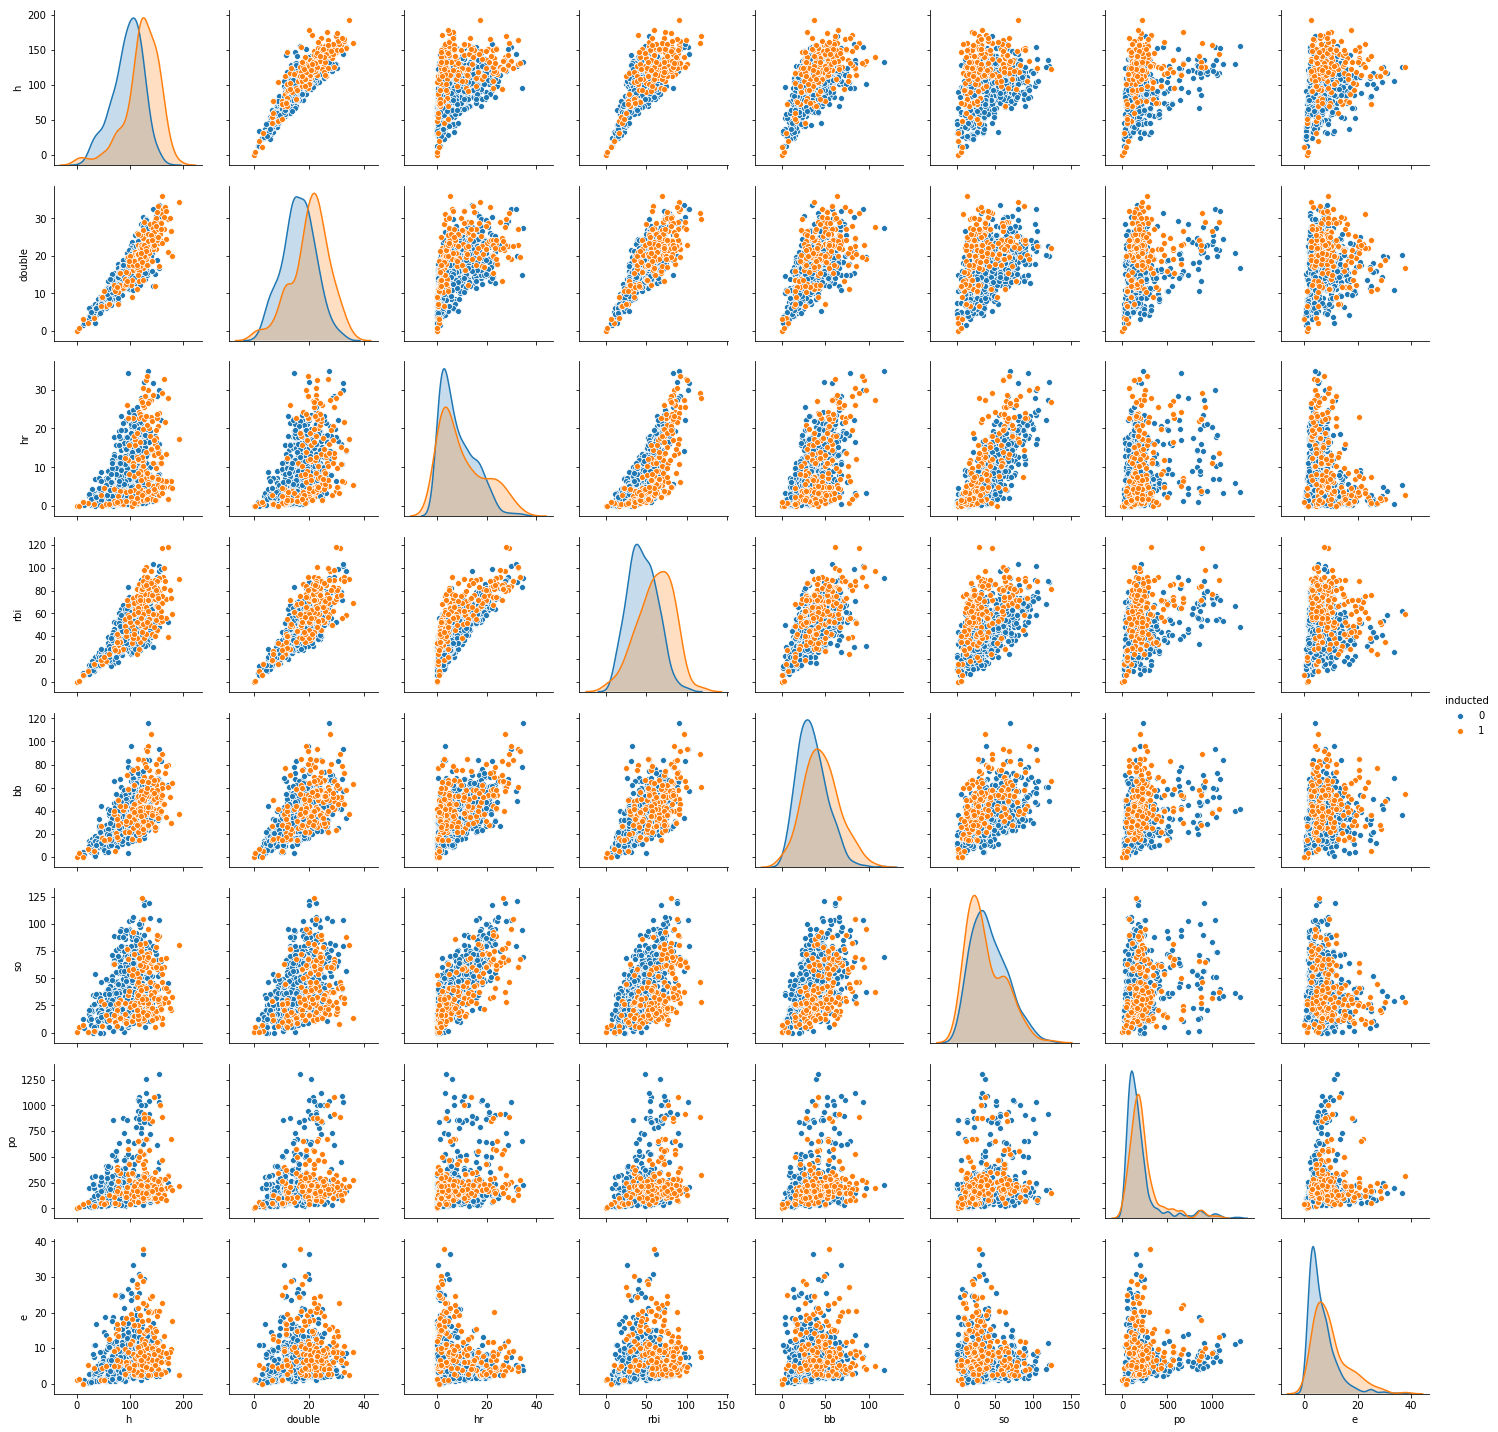

In [444]:
sns.pairplot(data=data,hue='inducted',vars=['h', 'double', 'hr', 'rbi', 'bb', 'so', 'po', 'e'])

In [431]:
# Avg. number of awards for player in hall of fame vs not. 
print(data[data.inducted==1]['awards'].sum()/len(data[data.inducted==1]))
print(data[data.inducted==0]['awards'].sum()/len(data[data.inducted==0]))

10.011494252873563
2.6739130434782608


In [135]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

Using TensorFlow backend.


In [354]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [358]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [355]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_strain, y_strain = ros.fit_resample(X_train, y_train)

In [359]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='liblinear',
                         class_weight='balanced')
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [349]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_strain, y_strain)

y_pred = classifier.predict(X_test)

In [351]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_strain, y_strain)

y_pred = clf.predict(X_test)

In [360]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[90 21]
 [14 30]]
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       111
           1       0.59      0.68      0.63        44

    accuracy                           0.77       155
   macro avg       0.73      0.75      0.73       155
weighted avg       0.79      0.77      0.78       155

